## Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

In [2]:
from __future__ import annotations

import pickle

import matplotlib.pyplot as plt
import numpy as np

from network_utils import (
    create_56bus,
    create_RX_from_net,
    read_load_data)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# hide top and right splines on plots
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
time_ticks =  [   0, 2400, 4800,  7200,  9600, 12000, 14400]
time_labels = ['0h', '4h', '8h', '12h', '16h', '20h', '24h']

vmin = 11.4  # kV
vmax = 12.6

v_nom = 12**2  # nominal squared voltage magnitude, units kV^2
v_sub = v_nom  # fixed squared voltage magnitude at substation, units kV^2

ylim = (11.1, 13.4)

# even tho min-voltage node is 35, we'll use node 29 instead
buses = [17, 29]

## Load Data

In [4]:
net = create_56bus()
R, X = create_RX_from_net(net, noise=0)  # true R and X
p, qe = read_load_data()  # in MW and MVar
T, n = p.shape

vpars = qe @ X + p @ R + v_sub  # shape [T, n]

In [5]:
def setup_voltage_ax(ax):
    ax.axhline(vmin, ls='--', color='black')
    ax.axhline(vmax, ls='--', color='black')
    ax.set(xlim=(-100, T), xticks=time_ticks, xticklabels=time_labels)
    ax.set(ylim=ylim, ylabel='voltage (kV)')

def savefig(fig, path):
    fig.savefig(path, dpi=200, pad_inches=0, bbox_inches='tight')

## USA Solar Generation, 2010-21

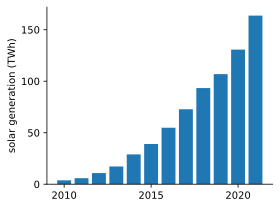

In [6]:
# source: https://www.eia.gov/totalenergy/data/browser/index.php?tbl=T10.06
solar_generation = np.array([
    3750, 5851, 10823, 17217, 28924, 39032,
    54866, 72777, 93365, 106894, 130721, 163703])  # in GWh
solar_generation_TWh = solar_generation / 1000
years = list(range(2010, 2022))
fig, ax = plt.subplots(1, 1, figsize=(4,3), tight_layout=True)
ax.bar(years, solar_generation_TWh)
ax.set(ylabel='solar generation (TWh)')
xticks = [2010, 2015, 2020]
yticks = [0, 50, 100, 150]
ax.set(xticks=xticks, xticklabels=[str(y) for y in xticks])
ax.set(yticks=yticks, yticklabels=[str(y) for y in yticks])
savefig(fig, path='plots/usa_solar_generation.svg')

## No control vs. perfect control

In [7]:
print('max-voltage node:', vpars.max(axis=0).argmax())
print('min-voltage node:', vpars.min(axis=0).argmin())

max-voltage node: 17
min-voltage node: 35


In [8]:
with open('out/CBCconst_20220211_052507.pkl', 'rb') as f:
    perf_ctrl = pickle.load(f)
    print(list(perf_ctrl.keys()))

['vs', 'qcs', 'dists', 'params', 'elapsed', 'X_init']


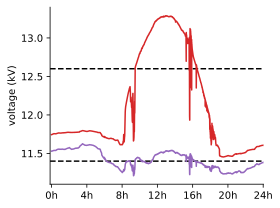

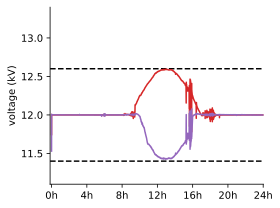

In [9]:
figs, axs = [], []
for i in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    setup_voltage_ax(ax)
    figs.append(fig)
    axs.append(ax)

colors = ['tab:red', 'tab:purple']
for i, node in enumerate(buses):
    axs[0].plot(np.sqrt(vpars[:, node]), c=colors[i])
    axs[1].plot(np.sqrt(perf_ctrl['vs'][:, node]), c=colors[i])

savefig(figs[0], path='plots/no_control.svg')
savefig(figs[1], path='plots/perf_control.svg')

## Decentralized Control

In [10]:
with open('out/decentralized_opt.pkl', 'rb') as f:
    decentral = pickle.load(f)

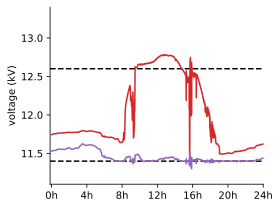

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
setup_voltage_ax(ax)

colors = ['tab:red', 'tab:purple']
for i, node in enumerate(buses):
    ax.plot(np.sqrt(decentral['vs'][:, node]), c=colors[i])
savefig(fig, path='plots/decentral_opt.svg')

## Wrong Model

In [12]:
with open('out/no_diag_constr/CBCconst_noise1.0_perm_norm1.0_seed8_Pu100_20220316_233154.pkl', 'rb') as f:
    wrong_model = pickle.load(f)
print(wrong_model.keys())

dict_keys(['vs', 'qcs', 'dists', 'params', 'elapsed', 'X_init'])


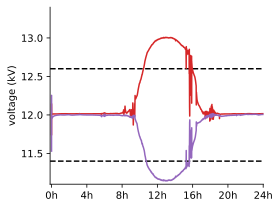

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
setup_voltage_ax(ax)

colors = ['tab:red', 'tab:purple']
for i, node in enumerate(buses):
    ax.plot(np.sqrt(wrong_model['vs'][:, node]), c=colors[i])

savefig(fig, path='plots/wrong_model.svg')

## Experimental Results: medium uncertainty

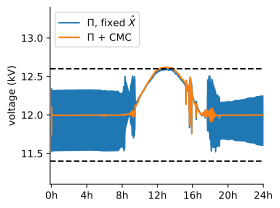

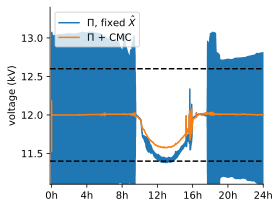

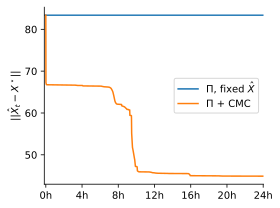

In [14]:
figs, axs = [], []
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    figs.append(fig)
    axs.append(ax)

label = '$\Pi$, fixed $\hat{X}$'
color = 'tab:blue'
path = 'out/CBCconst_noise0.5_perm_norm0.5_seed55_20220211_123509.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)
axs[2].axhline(data['dists']['true'], color=color, label=label)

# collect controller+cbc voltage profiles
label = '$\Pi$ + CMC'
color = 'tab:orange'
path = 'out/CBCproj_noise0.5_perm_norm0.5_seed55_20220211_132214.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)
axs[2].plot(data['dists']['t'] + [T], data['dists']['true'] + [data['dists']['true'][-1]],
            color=color, label=label)
axs[2].set_ylabel(r'$||\hat{X}_t - X^\star||$')

for ax in [axs[0], axs[1]]:
    setup_voltage_ax(ax)

axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[2].legend()

axs[2].set(xlim=(-100, T), xticks=time_ticks, xticklabels=time_labels)

for i, fig in enumerate(figs):
    savefig(fig, path=f'plots/acm_med_med_{i}.png')

## Compare perfect controller vs. learned controller

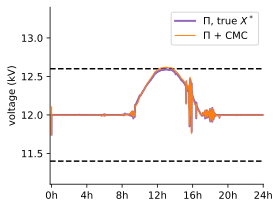

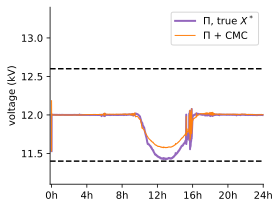

In [15]:
figs, axs = [], []
for i in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi=60, tight_layout=True)
    setup_voltage_ax(ax)
    figs.append(fig)
    axs.append(ax)

# bus 19
with open('out/CBCconst_20220211_052507.pkl', 'rb') as f:
    data = pickle.load(f)
for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), c='tab:purple', lw=2, label='$\Pi$, true $X^*$')

# bus 31
with open('out/CBCproj_noise0.5_perm_norm0.5_seed55_20220211_132214.pkl', 'rb') as f:
    data = pickle.load(f)
for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), c='tab:orange', lw=1, label='$\Pi$ + CMC')

for ax in axs:
    ax.legend()
savefig(figs[0], path='plots/perf_vs_learned_bus19.svg')
savefig(figs[1], path='plots/perf_vs_learned_bus31.svg')

## Experiments: Increased uncertainty

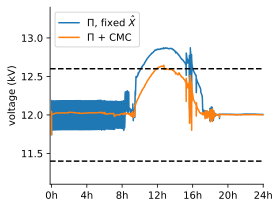

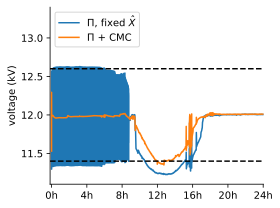

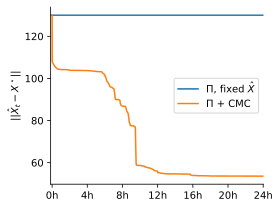

In [16]:
figs, axs = [], []
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    figs.append(fig)
    axs.append(ax)

label = '$\Pi$, fixed $\hat{X}$'
color = 'tab:blue'
path = 'out/CBCconst_noise1.0_perm_norm1.0_seed10_20220211_133640.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)
axs[2].axhline(data['dists']['true'], color=color, label=label)

# collect controller+cbc voltage profiles
label = '$\Pi$ + CMC'
color = 'tab:orange'
path = 'out/CBCproj_noise1.0_perm_norm1.0_seed10_20220211_133535.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)
axs[2].plot(data['dists']['t'] + [T], data['dists']['true'] + [data['dists']['true'][-1]],
            color=color, label=label)

for ax in [axs[0], axs[1]]:
    setup_voltage_ax(ax)

axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[2].legend()

axs[2].set(xlim=(-100, T), xticks=time_ticks, xticklabels=time_labels)
axs[2].set_ylabel(r'$||\hat{X}_t - X^\star||$')

for i, fig in enumerate(figs):
    savefig(fig, path=f'plots/acm_lrg_lrg_{i}.png')

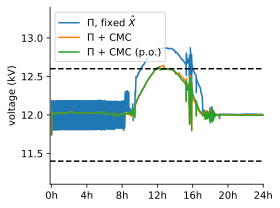

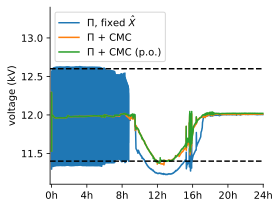

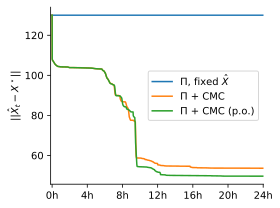

In [17]:
figs, axs = [], []
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    figs.append(fig)
    axs.append(ax)

label = '$\Pi$, fixed $\hat{X}$'
color = 'tab:blue'
path = 'out/CBCconst_noise1.0_perm_norm1.0_seed10_20220211_133640.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)
axs[2].axhline(data['dists']['true'], color=color, label=label)

# collect controller+cbc voltage profiles
label = '$\Pi$ + CMC'
color = 'tab:orange'
path = 'out/CBCproj_noise1.0_perm_norm1.0_seed10_20220211_133535.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)
axs[2].plot(data['dists']['t'] + [T], data['dists']['true'] + [data['dists']['true'][-1]],
            color=color, label=label)

# collect controller+cbc (partial obs) voltage profiles
label = '$\Pi$ + CMC (p.o.)'
color = 'tab:green'
path = 'out/CBCproj_noise1.0_perm_norm1.0_seed10_partialobs_20220428_213038.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)
axs[2].plot(data['dists']['t'] + [T], data['dists']['true'] + [data['dists']['true'][-1]],
            color=color, label=label)

for ax in [axs[0], axs[1]]:
    setup_voltage_ax(ax)

axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[2].legend()

axs[2].set(xlim=(-100, T), xticks=time_ticks, xticklabels=time_labels)
axs[2].set_ylabel(r'$||\hat{X}_t - X^\star||$')

for i, fig in enumerate(figs):
    savefig(fig, path=f'plots/acm_lrg_lrg_partial_{i}.png')

# comparison against baselines

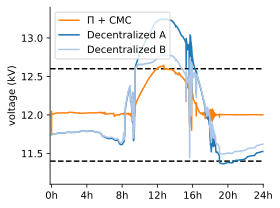

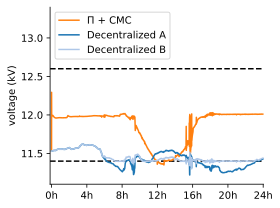

In [18]:
figs, axs = [], []
for i in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    setup_voltage_ax(ax)
    figs.append(fig)
    axs.append(ax)

# collect controller+cbc voltage profiles
label = '$\Pi$ + CMC'
color = 'tab:orange'
path = 'out/CBCproj_noise1.0_perm_norm1.0_seed10_20220211_133535.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)

# baseline A voltage profile
label = 'Decentralized A'
color = 'tab:blue'
path = 'out/decentralized_feasible.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)

# baseline B voltage profile
label = 'Decentralized B'
color = plt.cm.tab20.colors[1]
path = 'out/decentralized_opt.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

for i, node in enumerate(buses):
    axs[i].plot(np.sqrt(data['vs'][:, node]), color=color, label=label)

for ax in axs:
    ax.legend(loc='upper left')

savefig(figs[0], path=f'plots/vs_baseline_bus19.png')
savefig(figs[1], path=f'plots/vs_baseline_bus31.png')